In [16]:
'''
(C) Copyright Renata Wong 2023.

This code is licensed under the Apache License, Version 2.0. You may obtain a copy of this license 
at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this copyright notice, and modified files 
need to carry a notice indicating that they have been altered from the originals.

For details see 
Piotr Czarnik, Andrew Arrasmith, Patrick J. Coles, and Lukasz Cincio. 
"Error mitigation with Clifford quantum-circuit data". Quantum 5, 592 (2021).
'''

from qiskit import QuantumCircuit, QuantumRegister
import numpy as np

# imports for generating training circuits
from qiskit.circuit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import TransformationPass
import numpy as np
import random
from random import choices

In [ ]:
nqubits = 3
nshots = 2500 # Aumentar para 20.000 depois

def getParity(n):
    parity = 0
    while n:
        parity = ~parity
        n = n & (n - 1)
    return parity

import itertools
def expectation_value_from_counts(counts):
    exp_val = 0
    for x in map(''.join, itertools.product('01', repeat=nqubits)):
        if x in counts:   # making sure that x is in the output as the counts dictionary contains no values with 0 occurrence
            if getParity(int(x,2)) == -1:
                exp_val = exp_val - counts[x]
            if getParity(int(x,2)) == 0:
                exp_val = exp_val + counts[x]
    return exp_val/nshots

# mapping circuit to near Clifford circuits with N = number of non-Clifford gates
# Z gates with these angles/exponents are Clifford gates.
clifford_exponents = np.array([0.0, 0.5, 1.0, 1.5])
clifford_angles = [exponent * np.pi for exponent in clifford_exponents]


# replacing some non-Clifford gates with Clifford gates in the input circuit
class RZTranslator(TransformationPass):
    """A transpiler pass to replace RZ(a) gates with RZ(pi/2)^n gates, for n = 0, 1, 2, 3 at random."""

    def run(self, dag):
        N = 0.3 # TUNABLE: here, replace 30% of the non-Clifford gates
        # iterate over all operations
        for node in dag.op_nodes():

            # if we hit a RZ gate replace it by RZ(pi/2)^n at random
            if node.op.name in ["rz"]:
                # get the rotation angle
                angle = node.op.params[0]

                # calculate the replacement
                replacement = QuantumCircuit(1)
                if node.op.name == "rz":
                    if angle not in clifford_angles:
                        if choices([0,1], [N, 1-N])[0] == 0:
                            replacement.rz(random.choice(clifford_angles),0)
                        else:
                            replacement.rz(angle,0)

                # replace the node with our new decomposition
                dag.substitute_node_with_dag(node, circuit_to_dag(replacement))
        return dag
   
    
# Least-squares regression from scipy
#from scipy.stats import linregress
def least_squares_regression(noiseless_exp_vals, noisy_exp_vals):
    result = scipy.stats.linregress(noisy_exp_vals, noiseless_exp_vals)
    return (result.slope, result.intercept)




'''
EXAMPLE CIRCUIT. ADJUSTABLE. 
'''
qc = QuantumCircuit(nqubits)

qc.ry(0, 0)
qc.rz(0.369599140, 0)
qc.ry(0.73919827, 1)
qc.rz(1.10879741, 1)
qc.ry(1.47839654, 2)
qc.rz(1.84799568, 2)
qc.cx(0, 1)
qc.cx(1, 2)
qc.ry(2.21759481, 0)
qc.rz(2.58719395, 0)
qc.ry(2.95679309, 1)
qc.rz(3.32639222, 1)
qc.ry(3.69599136, 2)
qc.rz(4.06559049, 2)
qc.cx(0, 1)
qc.cx(1, 2)
qc.ry(4.43518963, 0)
qc.rz(4.80478876, 0)
qc.ry(5.1743879, 1)
qc.rz(5.54398704, 1)
qc.ry(5.91358617, 2)
qc.rz(6.28318531, 2)
qc.cx(0, 1)
qc.cx(1, 2)

training_circuits_no_measurement_all = []  
for _ in range(500): 
    training_circuits_no_measurement_all.append(RZTranslator()(qc))

print(*training_circuits_no_measurement_all)

In [19]:
# wrapping the circuit into a statefunction
# This does not take simulation output into account, hence is always the same, while simulation with measurement varies.
from qiskit import quantum_info
from qiskit.quantum_info import SparsePauliOp, Pauli, Statevector
from qiskit.primitives import Estimator


In [22]:
observable = SparsePauliOp(['IIZ', 'IZI', 'ZII'], coeffs=[-1.+0.j, -1.+0.j, -1.+0.j])

# expectation value of the original circuit
psi_qc = Statevector(qc)
exp = psi_qc.expectation_value(observable)
print(exp)
exp_val_qc = psi_qc.evolve(observable) #(~psi_qc @ observable @ psi_qc).eval()
estimator = Estimator()
exp_val_qc = estimator.run(qc, observable).result().values
print('Exact expectation value of circuit of interest:', real)


noiseless_exp_vals = []
training_circuits_no_measurement = []
for circuit in training_circuits_no_measurement_all: 
    psi = Statevector(circuit)

    expectation_value = psi.evolve(observable)
    estimator = Estimator()
    result = estimator.run(circuit, observable).result()
    values = result.values
    expectation_value = values.real

    # criterio low loss
    if expectation_value >= exp_val_qc.real-0.05 and expectation_value <= exp_val_qc.real+0.05:
        noiseless_exp_vals.append(expectation_value.real)
        training_circuits_no_measurement.append(circuit)

for exp_val in noiseless_exp_vals:
    print('Exact expectation value:', exp_val)

(0.5927156177933097+0j)
Exact expectation value of circuit of interest: [0.59271562]


AttributeError: 'Statevector' object has no attribute 'real'

In [7]:
'''
Generate training circuits with measurement for noisy simulation on quantum devices
'''


from qiskit import ClassicalRegister

# original circuit with measurement
qr_qc = QuantumRegister(nqubits)
cr_qc = ClassicalRegister(nqubits)
circ_qc = QuantumCircuit(qr_qc, cr_qc)
circ_qc.append(qc.to_instruction(), [qubit for qubit in range(nqubits)])
circ_qc.measure(qr_qc, cr_qc)


training_circuits_with_measurement = []
for circuit in training_circuits_no_measurement:
    qr = QuantumRegister(nqubits)
    cr = ClassicalRegister(nqubits)
    circ = QuantumCircuit(qr, cr)
    circ.append(circuit.to_instruction(), [qubit for qubit in range(nqubits)])
    circ.measure(qr, cr) 
    training_circuits_with_measurement.append(circ)
    
print(*training_circuits_with_measurement)

      ┌──────────────┐┌─┐      
q3_0: ┤0             ├┤M├──────
      │              │└╥┘┌─┐   
q3_1: ┤1 circuit-158 ├─╫─┤M├───
      │              │ ║ └╥┘┌─┐
q3_2: ┤2             ├─╫──╫─┤M├
      └──────────────┘ ║  ║ └╥┘
c3: 3/═════════════════╩══╩══╩═
                       0  1  2        ┌──────────────┐┌─┐      
q4_0: ┤0             ├┤M├──────
      │              │└╥┘┌─┐   
q4_1: ┤1 circuit-158 ├─╫─┤M├───
      │              │ ║ └╥┘┌─┐
q4_2: ┤2             ├─╫──╫─┤M├
      └──────────────┘ ║  ║ └╥┘
c4: 3/═════════════════╩══╩══╩═
                       0  1  2        ┌──────────────┐┌─┐      
q5_0: ┤0             ├┤M├──────
      │              │└╥┘┌─┐   
q5_1: ┤1 circuit-158 ├─╫─┤M├───
      │              │ ║ └╥┘┌─┐
q5_2: ┤2             ├─╫──╫─┤M├
      └──────────────┘ ║  ║ └╥┘
c5: 3/═════════════════╩══╩══╩═
                       0  1  2        ┌──────────────┐┌─┐      
q6_0: ┤0             ├┤M├──────
      │              │└╥┘┌─┐   
q6_1: ┤1 circuit-158 ├─╫─┤M├───
      │ 

In [11]:
from qiskit_braket_provider import BraketProvider
from qiskit import transpile

provider = BraketProvider()
backend = provider.get_backend("Aria 1")

noisy_exp_vals = []   
for circuit in training_circuits_with_measurement: 
    tqc = transpile(circuit, backend) 
    result_noise = backend.run(tqc, shots=nshots).result() 
    counts_noise = result_noise.get_counts(0) 
    noisy_exp_val = expectation_value_from_counts(counts_noise) 
    print('Noisy expectation value from counts: ', noisy_exp_val)
    noisy_exp_vals.append(noisy_exp_val)

KeyboardInterrupt: 

In [12]:
online_simulators_backends = provider.backends(statuses=["ONLINE"], types=["SIMULATOR"])
print(online_simulators_backends)

[BraketBackend[SV1], BraketBackend[TN1], BraketBackend[dm1]]


In [172]:
'''
Adding a noise model to our simulation
'''
import qiskit_aer
backend=qiskit_aer.Aer.get_backend('qasm_simulator')

from qiskit import transpile

from qiskit.providers.fake_provider  import GenericBackendV2




Noisy expectation value from counts:  0.022
Noisy expectation value from counts:  -0.03
Noisy expectation value from counts:  0.364
Noisy expectation value from counts:  0.006
Noisy expectation value from counts:  0.04
Noisy expectation value from counts:  -0.012
Noisy expectation value from counts:  0.38
Noisy expectation value from counts:  0.082
Noisy expectation value from counts:  -0.012
Noisy expectation value from counts:  0.028
Noisy expectation value from counts:  0.092
Noisy expectation value from counts:  0.164
Noisy expectation value from counts:  -0.05
Noisy expectation value from counts:  0.004
Noisy expectation value from counts:  -0.022
Noisy expectation value from counts:  0.006
Noisy expectation value from counts:  0.014
Noisy expectation value from counts:  0.068
Noisy expectation value from counts:  0.08
Noisy expectation value from counts:  -0.034
Noisy expectation value from counts:  0.04
Noisy expectation value from counts:  0.058
Noisy expectation value from cou

In [144]:
import scipy

result = least_squares_regression(noiseless_exp_vals, noisy_exp_vals)

slope = result[0]
intercept = result[1]
print('Slope: ', slope, ' Intercept: ', intercept)

Slope:  0.49728587852838435  Intercept:  0.1032250934709388


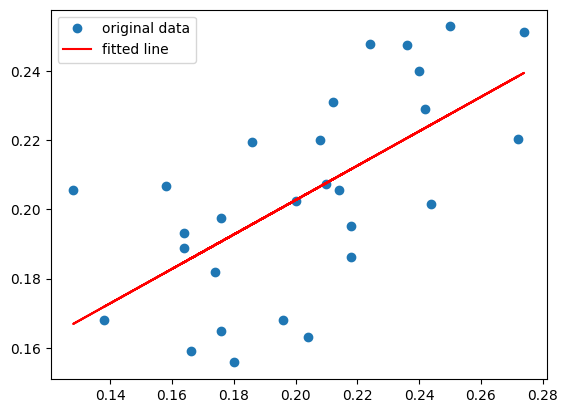

In [145]:
import matplotlib.pyplot as plt
plt.plot(noisy_exp_vals, noiseless_exp_vals, 'o', label='original data')
noisy_exp_vals = np.array(noisy_exp_vals)
plt.plot(noisy_exp_vals, slope*noisy_exp_vals + intercept, 'r', label='fitted line')

plt.legend()
plt.show()

In [146]:
'''
Prediction: run the original circuit and measure (= X_exact). 
Then, apply the function X_exact = slope*X_noisy + intercept to obtain the mitigated value. 
'''


# Running classical simulation
#from qiskit import execute
from qiskit.primitives import BackendSampler
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector


# Testing: classical exact expectation value from the original circuit

psi_test = Statevector(qc)
state_vector_test = psi_test.evolve(observable)
estimator = Estimator()
exact_exp_val_test = estimator.run(qc, observable).result().values.real
print('Exact expectation value: ', exact_exp_val_test)

Exact expectation value:  [0.2042226]


In [128]:

'''
For execution on qasm simulator: 
simulator = Aer.get_backend('qasm_simulator')
exact_result = execute(qc, simulator, shots=nshots).result()
exact_counts = exact_result.get_counts(qc)
exact_exp_val = expectation_value_from_counts(exact_counts)
print('Exact expectation value from counts: ', exact_exp_val)
'''

# Testing: quantum noisy expectation value on the original circuit


import qiskit_aer
backend=qiskit_aer.Aer.get_backend('qasm_simulator')
from qiskit import transpile
from qiskit.primitives import BackendSampler


'''
For execution on quantum backends: 
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_lima')

tqc = transpile(qc_, qcomp) 
unmitigated_result = execute(qc, backend=qcomp, shots=nshots).result()
unmitigated_counts = unmitigated_result.get_counts(0) 
unmitigated_exp_val = expectation_value_from_counts(unmitigated_counts) 
print('Unmitigated expectation value from counts: ', unmitigated_exp_val)

'''
"""
backend = BackendSampler(backend)
unmitigated_result = sampler.run(circ_qc)
print(unmitigated_result)
"""
tqc = transpile(circuit, backend) 
unmitigated_result = backend.run(tqc, shots=nshots).result() 
unmitigated_counts = unmitigated_result.get_counts(0) 
unmitigated_exp_val = expectation_value_from_counts(unmitigated_counts) 
print('Noisy expectation value from counts: ', unmitigated_exp_val)

Noisy expectation value from counts:  0.1909


In [135]:
"""
unmitigated_result = execute(circ_qc, backend=backend, shots=nshots).result() 
unmitigated_counts = unmitigated_result.get_counts(0) 
unmitigated_exp_val = expectation_value_from_counts(unmitigated_counts) 
"""
print('Exact expectation value: ', exact_exp_val_test)

# Mitigation
mitigated_exp_val = slope*unmitigated_exp_val + intercept
print('Mitigated expectation value from counts:', mitigated_exp_val)


# Error calculation

error_unmitigated = abs(unmitigated_exp_val-exact_exp_val_test)
error_mitigated = abs(mitigated_exp_val-exact_exp_val_test)
print("Error (unmitigated):", error_unmitigated)
print("Error (mitigated with CDR):", error_mitigated)

print("Relative error (unmitigated):", (error_unmitigated/exact_exp_val_test))
print("Relative error (mitigated with CDR):", error_mitigated/exact_exp_val_test)


print(f"Error reduction with CDR: {(error_unmitigated-error_mitigated)/error_unmitigated}")

Exact expectation value:  [0.2042226]
Mitigated expectation value from counts: 0.1935506107276922
Error (unmitigated): [0.0133226]
Error (mitigated with CDR): [0.01067199]
Relative error (unmitigated): [0.06523568]
Relative error (mitigated with CDR): [0.05225666]
Error reduction with CDR: [0.19895595]


In [ ]:
Exact expectation value:  0.20422260124463615
Mitigated expectation value from counts: 0.20140528209069625
Error (unmitigated): 0.06392260124463614
Error (mitigated with CDR): 0.002817319153939901
Relative error (unmitigated): 0.31300453943422213
Relative error (mitigated with CDR): 0.013795334780625302
Error reduction with CDR: 95.6%.